# Lab5: Second-Order Systems and Linear Quadratic Regulator (LQR)

This lab will practice how to decide where to place the eigenvalues to desired performances. We will use two approaches, one rely on the standard second order system, another one based on the linear quadratic regulators (LQR). Specifically, we will

- Analyze the effects of damping ratio and natural frequency on system response for a 2nd order system
- Design state-feedback controllers to meet specific performance criteria (settling time, overshoot)
- Implement and tune LQR controllers, exploring the impact of weighting matrices
- Simulate and visualize open-loop and closed-loop system responses using the Python Control Systems Library

By completing this lab, you will develop practical skills in modern control design, including eigenvalue assignment, reference tracking, and performance verification for mechanical systems.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
try:
  import control as ctl
  print("python-control", ctl.__version__)
except ImportError:
  !pip install control
  import control as ctl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 578.3/578.3 kB 11.2 MB/s eta 0:00:00


## Task 1: Second order system

Consider the standard form of a second-order ordinary differential equation (ODE):

$$
\frac{d^2q}{dt^2} + 2\zeta\omega_0 \frac{dq}{dt} + \omega_0^2 q = k \omega_0^2 u(t)
$$

where:
- $q$ is the output,
- $u(t)$ is the input,
- $\omega_0$ is the natural frequency,
- $\zeta$ is the damping ratio,
- $k$ is the DC gain.

To convert this ODE into state-space form, define the state variables:
- $x_1 = q$
- $x_2 = \frac{dq}{dt}$

Then, the state-space representation is:

$$
\begin{aligned}
\frac{d}{dt}
\begin{bmatrix}
x_1 \\
x_2
\end{bmatrix}
&=
\begin{bmatrix}
0 & 1 \\
-\omega_0^2 & -2\zeta\omega_0
\end{bmatrix}
\begin{bmatrix}
x_1 \\
x_2
\end{bmatrix}
+
\begin{bmatrix}
0 \\
k\omega_0^2
\end{bmatrix}
u(t) \\
y &= \begin{bmatrix} 1 & 0 \end{bmatrix}
\begin{bmatrix}
x_1 \\
x_2
\end{bmatrix}
\end{aligned}
$$

This form is used for simulation and analysis of second-order systems in control engineering.

We first try to see how the damping ratio $\zeta$ will influecen the shape of the step response by fixing the natural frequency.

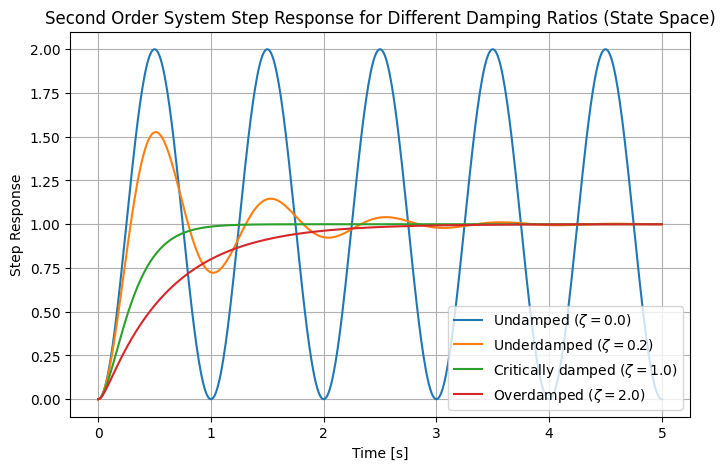

In [7]:
# Parameters
k = 1
omega_0 = 2 * np.pi  # 1 Hz natural frequency to standard unit rad/s

# Damping ratios for each case
zeta_cases = {
    "Undamped": 0.0,
    "Underdamped": 0.2,
    "Critically damped": 1.0,
    "Overdamped": 2.0
}

t = np.linspace(0, 5, 500)
plt.figure(figsize=(8, 5))

for label, zeta in zeta_cases.items():
    A = np.array([[0, 1], [-omega_0**2, -2*zeta*omega_0]])
    B = np.array([[0], [k * omega_0**2]])
    C = np.array([[1, 0]])
    D = np.array([[0]])
    sys = ctl.ss(A, B, C, D)
    t_out, y_out = ctl.step_response(sys, t)
    plt.plot(t_out, y_out, label=f"{label} ($\\zeta={zeta}$)")

plt.xlabel("Time [s]")
plt.ylabel("Step Response")
plt.title("Second Order System Step Response for Different Damping Ratios (State Space)")
plt.legend()
plt.grid(True)
plt.show()

We will then see how the natural frequency $\omega_0$ influences the speed of response by fixing zeta=0.707

<>:17: SyntaxWarning: invalid escape sequence '\o'
<>:17: SyntaxWarning: invalid escape sequence '\o'
/tmp/ipython-input-1353051547.py:17: SyntaxWarning: invalid escape sequence '\o'
  plt.title("Effect of $\omega_0$ on Second Order System Response ($\\zeta=0.707$)")


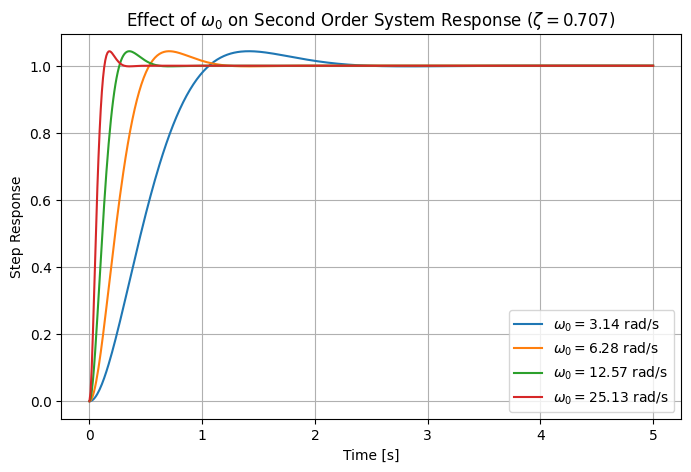

In [8]:
# Illustrate how omega_0 influences the response by fixing zeta=0.707
zeta = 0.707
omega_0_values = [2 * np.pi * f for f in [0.5, 1, 2, 4]]  # 0.5Hz, 1Hz, 2Hz, 4Hz

plt.figure(figsize=(8, 5))
for omega_0 in omega_0_values:
    A = np.array([[0, 1], [-omega_0**2, -2*zeta*omega_0]])
    B = np.array([[0], [k * omega_0**2]])
    C = np.array([[1, 0]])
    D = np.array([[0]])
    sys = ctl.ss(A, B, C, D)
    t_out, y_out = ctl.step_response(sys, t)
    plt.plot(t_out, y_out, label=f"$\\omega_0={omega_0:.2f}$ rad/s")

plt.xlabel("Time [s]")
plt.ylabel("Step Response")
plt.title("Effect of $\omega_0$ on Second Order System Response ($\\zeta=0.707$)")
plt.legend()
plt.grid(True)
plt.show()

## Task 2: Design state-feedback controller to achieve desired performance

Now let's use the mass-spring-damper system to illustrate how to design a state-feedback controller to achieve desired performance metrics. The mass-spring-damper system is governed by the second-order ODE:
$$
m\ddot{q} + b\dot{q} + kq = u(t)
$$
where $m$ is the mass, $b$ is the damping coefficient, $k$ is the spring constant, and $u(t)$ is the input force.

Assuming $m = 1$, $b = 1$, and $k = 1$, the equation simplifies to:
$$
\ddot{q} + \dot{q} + q = u(t)
$$

This can be written in state-space form as:
$$
\dot{x} = Ax + Bu
$$
where
$$
A = \begin{bmatrix} 0 & 1 \\ -1 & -1 \end{bmatrix}, \quad B = \begin{bmatrix} 0 \\ 1 \end{bmatrix}
$$

If we design a state feedback controller:
$$
u = -Kx = -\begin{bmatrix} k_1 & k_2 \end{bmatrix} x
$$
then the closed-loop system becomes:
$$
A_{cl} = A-BK= \begin{bmatrix} 0 & 1 \\ -1-k_1 & -1-k_2 \end{bmatrix}
$$

We want to achieve:
- Settling time $T_s < 1$ s
- Overshoot $M_p < 5\%$

The standard second-order system relationships are:
$$
T_s \approx \frac{4}{\zeta \omega_0}
$$
$$
M_p = e^{-\frac{\pi \zeta}{\sqrt{1-\zeta^2}}}
$$

Below is code to solve for the required $\zeta$ and $\omega_0$ to meet these specifications:

Required zeta: 0.690
Required omega_0: 5.796 rad/s


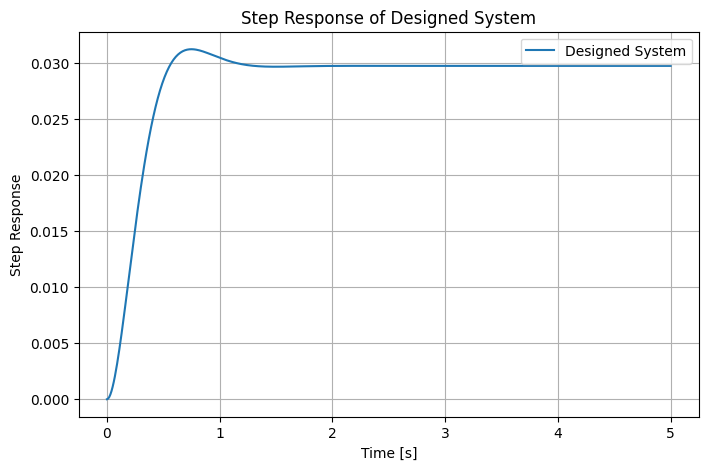

Step Response Info:


{'RiseTime': 0.3663203557035981,
 'SettlingTime': 1.0466295877245662,
 'SettlingMin': 0.026971499484878807,
 'SettlingMax': 0.031253695988503714,
 'Overshoot': 4.9998889807731075,
 'Undershoot': 0.0,
 'Peak': 0.031253695988503714,
 'PeakTime': 0.7500845378692724,
 'SteadyStateValue': 0.029765456222745804}

In [9]:
from scipy.optimize import fsolve

# Desired specifications
Ts_max = 1      # Settling time < 1 s
Mp_max = 0.05   # Overshoot < 5%

# Solve for minimum zeta from overshoot specification
def overshoot_eq(zeta):
    return np.exp(-np.pi * zeta / np.sqrt(1 - zeta**2)) - Mp_max

zeta_guess = 0.7
zeta_req = fsolve(overshoot_eq, zeta_guess)[0]

# Solve for minimum omega_0 from settling time specification
omega_0_req = 4 / (zeta_req * Ts_max)

print(f"Required zeta: {zeta_req:.3f}")
print(f"Required omega_0: {omega_0_req:.3f} rad/s")

# Verify the design
# Compute state feedback gains k1 and k2 for desired omega_0 and zeta
# k1 and k2 are chosen to place the closed-loop poles at the desired location
# For a second-order system, the characteristic equation is:
# s^2 + 2*zeta*omega_0*s + omega_0^2 = 0
# State feedback places the eigenvalues at s^2 + (1 + k2)*s + (1 + k1) = 0
# Matching coefficients gives:
k1 = omega_0_req**2 - 1      # ensures desired natural frequency
k2 = 2 * zeta_req * omega_0_req - 1  # ensures desired damping ratio

# Form the closed-loop A matrix using state feedback
A = np.array([[0, 1], [-1 - k1, -1 - k2]])
B = np.array([[0], [1]])
C = np.array([[1, 0]])
D = np.array([[0]])
sys = ctl.ss(A, B, C, D)
t_out, y_out = ctl.step_response(sys, t)
plt.figure(figsize=(8, 5))
plt.plot(t_out, y_out, label="Designed System")
plt.xlabel("Time [s]")
plt.ylabel("Step Response")
plt.title("Step Response of Designed System")
plt.legend()
plt.grid(True)
plt.show()

step_info = ctl.step_info(sys)
print("Step Response Info:")
step_info

## Task 3: Linear quadratic regulator (LQR) design

Now we'll design a controller based on LQR. The controller will have the form

$$
u=-Kx+k_rr
$$

- For the feedback control gain $K$, we'll use linear quadratic regulator theory.  We seek to find the control law that minimizes the cost function:

  $$
  J(x(\cdot), u(\cdot)) = \int_0^\infty x^T(\tau) Q_x x(\tau) + u^T(\tau) Q_u u(\tau)\, d\tau
  $$

  The weighting matrices $Q_x\succeq 0 \in \mathbb{R}^{n \times n}$ and $Q_u \succ 0\in \mathbb{R}^{m \times m}$ should be chosen based on the desired performance of the system (tradeoffs in state errors and input magnitudes).  See Example 3.5 in [Optimization Based Control (OBC)](https://fbswiki.org/wiki/index.php/Supplement:_Optimization-Based_Control) for a discussion of how to choose these weights.  For now, we just choose identity weights for all states and inputs.

- For the feedforward control gain $k_r$, we derive the feedforward gain from an equilibrium point analysis:
  $$
  y_e = C(A-BK)^{-1}Bk_rr
  \qquad\implies\qquad k_r = \frac{-1}{C(A-BK)^{-1}B}
  $$

In [16]:
# Construct the mass-spring-damper system
A = np.array([[0, 1], [-1, -1]])
B = np.array([[0], [1]])
C = np.array([[1, 0]])
D = np.array([[0]])
sys = ctl.ss(A, B, C, D)

# Construct an LQR controller for the system
rho = 1 # constant to balance state and input weights
Qx = np.eye(sys.nstates) # create an identity matrix with size equal to number of states
Qu = np.eye(sys.ninputs) # create an identity matrix with size equal to number of inputs
Qu = rho * Qu # scale the input weight matrix
K, _, _ = ctl.lqr(sys, Qx, Qu) # compute the LQR gain matrix
print('K: '+str(K)) #str is to convert K to string for printing

# Set the feedforward gain to track the reference
kr = (-1 / (C @ np.linalg.inv(A - B @ K) @ B))
print('k_r: '+str(kr))

K: [[0.41421356 0.68179283]]
k_r: [[1.41421356]]


Now that we have our gains designed, we can simulate the closed loop system:
$$
\frac{dx}{dt} = A_{cl}x + B_{cl} r,
\quad A_{cl} = A-BK,
\quad B_{cl} = Bk_r
$$
Notice that, with a state feedback controller, the new (closed loop) dynamics matrix absorbs the old (open loop) "input" $u$, and the new (closed loop) input is our reference signal $r$.

In [20]:
# Create a closed loop system
A_cl = A - B @ K
B_cl =  B * kr
clsys = ctl.ss(A_cl, B_cl, C, 0)
print(clsys)

<StateSpace>: sys[20]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']
States (2): ['x[0]', 'x[1]']

A = [[ 0.          1.        ]
     [-1.41421356 -1.68179283]]

B = [[0.]
     [0.]]

C = [[1. 0.]]

D = [[0.]]


With the designed controller, we can now simulate the system to see its performance. We ask it to track a constant reference $r $:

Settling time: 0.000 s
Overshoot: 0.00 %


/usr/local/lib/python3.12/dist-packages/control/timeresp.py:1712: RuntimeWarning: invalid value encountered in divide
  np.abs(yout/InfValue - 1) >= SettlingTimeThreshold)[0]


Text(0.5, 1.0, 'Baseline controller step response')

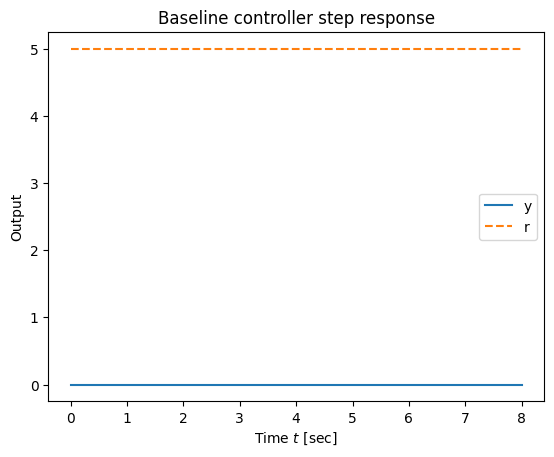

In [21]:
# Plot the step response with respect to the reference input
r = 5
Tf = 8
tvec = np.linspace(0, Tf, 100)

U = r * np.ones_like(tvec)
time, output = ctl.forced_response(clsys, tvec, U)

# Get step response info
info = ctl.step_info(clsys)
print(f"Settling time: {info['SettlingTime']:.3f} s")
print(f"Overshoot: {info['Overshoot']:.2f} %")
plt.plot(time, output)
plt.plot([time[0], time[-1]], [r, r], '--');
plt.legend(['y', 'r']);
plt.ylabel("Output")
plt.xlabel("Time $t$ [sec]")
plt.title("Baseline controller step response")

Things to try:
- set $k_r=0$
- set $k_r \neq \frac{-1}{C(A-BK)^{-1}B}$
- try different LQR weightings

# HW problems

## Problem 1

For this problem, consider the following second-order system with the state-space representation:
$$
\dot{x} = Ax + Bu, \quad y = Cx
$$
where
$$
A = \begin{bmatrix} 2 & 1 \\ 10 & -1 \end{bmatrix}, \quad B = \begin{bmatrix} 0 \\ 1 \end{bmatrix}, \quad C = \begin{bmatrix} 1 & 0 \end{bmatrix}, \quad D = 0
$$

**Tasks:**
1. **Manual Calculation:**      Design a state-feedback controller $u = -Kx$ to achieve a closed-loop system with a damping ratio $\zeta = 1/\sqrt{2}$ and natural frequency $\omega_0 = 2\pi$ rad/s ($1$ Hz).   Derive the feedback gain $K = [k_1, k_2]$ manually using the desired eigenvalue locations based on $\zeta$ and $\omega_0$.

2. **Programming problem:**      Write a program to compute the feedback gain $K$ for the above specifications and compare with your manual result.

3. **Programming problem:**    Design a state-feedback controller $u = -Kx$ to achieve:
    - Settling time $T_s < 1$ s
    - Overshoot $M_p < 5\%$
    
    Steps:
    - Compute the required damping ratio $\zeta$ and natural frequency $\omega_0$ using the standard second-order system formulas:
      $$
      T_s \approx \frac{4}{\zeta \omega_0}, \qquad
      M_p = e^{-\frac{\pi \zeta}{\sqrt{1-\zeta^2}}}
      $$
    - Determine the feedback gain $K$.
    - Simulate the step response of the closed-loop system and verify that the specifications are met.

4. **Programming problem:**  Design a LQR controller for the system:
    - Choose $Q_x$ and $Q_u$ as identity matrices, but use a ratio $\rho$ to balance $Q_x$ and $Q_u$ (i.e., $Q_u = \rho I$).
    - Explore how different values of $\rho$ influence the controller performance and explain your observations.


## Problem 2

This problem requires manual derivation. You may attach a PDF.

Assume a system has the following state–space representation
$$
\dot{x} =
\begin{bmatrix}
0 & 1\\
0 & -a
\end{bmatrix}x \;+\;
\begin{bmatrix}
0\\
1
\end{bmatrix}u,
\qquad
y = \begin{bmatrix} b & 1 \end{bmatrix} x
$$
and we want to minimize the following objective
$$
J=\int_{0}^{\infty} \big(x_1^2 + u^2\big)\, d\tau = \int_0^\infty x^T(\tau) Q_x x(\tau) + u^T(\tau) Q_u u(\tau)\, d\tau
$$

1. What is the numerical values of $Q_x$ and $Q_u$?
2. Let
  $$
    P=\begin{bmatrix}
    p_{11} & p_{12}\\
    p_{21} & p_{22}
    \end{bmatrix},
  $$
  with $p_{12}=p_{21}$ and $P>0$ (positive definite). Write the steady–state Riccati equation $PA + A^TP - PBR^{-1}B^TP + Q = 0$ as a system of four explicit equations in terms of the elements of $P$ and the constants $a$ and $b$. Solve $p_{11}$, $p_{12}$, $p_{22}$ as a function of $a$ and $b$.


2. Find the gains for the optimal controller $u=-Kx$ assuming the full state is available for feedback.